## Scraping Lineup Data
Source : https://www.baseball-reference.com/boxes/

Same for weather.ipynb, I was able to scrap lineup scores from the same website. <br/>
Lineup Scores are basically the average OPS(season-to-date) of the starting lineup.

In [7]:
import pandas as pd
import requests
import time

In [3]:
game_logs = pd.read_csv("../data/final_game_logs.csv")

<b>Function for safe float conversion</b>

In [9]:
def safe_float(v):
    try:
        return float(v)
    except:
        return None

<b>Function for extracting OPS of a player</b>

In [11]:
def extract_ops(player_obj):
    batting = player_obj.get("seasonStats", {}).get("batting", {})
    ops = safe_float(batting.get("ops"))
    if ops is not None:
        return ops
    return None

<b>Function for getting sorting lineup</b>

In [13]:
def get_starters(players_dict):
    starters = []
    for p in players_dict.values():
        if "battingOrder" in p:
            starters.append(p)
    starters.sort(key=lambda x : int(x.get("battingOrder", "999"))) #999 = Fail Code
    return starters

<b>Function for scraping by game_id, retreiving home/away starting lineups, and evaluating lineup score</b>

In [17]:
def lineup_score(gameid):
    url = f"https://statsapi.mlb.com/api/v1/game/{gameid}/boxscore"
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        return None
    data = r.json()

    teams = data.get("teams", {})
    home_players = teams.get("home", {}).get("players", {})
    away_players = teams.get("away", {}).get("players", {})

    home_ops = []
    for p in get_starters(home_players):
        ops_val = extract_ops(p)
        if ops_val is not None:
            home_ops.append(ops_val)

    away_ops = []
    for p in get_starters(away_players):
        ops_val = extract_ops(p)
        if ops_val is not None:
            away_ops.append(ops_val)

    return {
        "game_id" : gameid,
        "home_lineup_score" : sum(home_ops)/len(home_ops) if home_ops else None,
        "away_lineup_score" : sum(away_ops)/len(away_ops) if home_ops else None,
        "home_n_starters" : len(home_ops),
        "away_n_starters" : len(away_ops)
    }

In [31]:
# Run Only Once, May take a while
results = []
total_games = len(game_logs)
for i, id in enumerate(game_logs['game_id'], start=1):
    try:
        row = lineup_score(id)
        results.append(row)
    except Exception as e:
        print(f"Error {id}: {e}")
    time.sleep(0.05)
    
    if i % 100 == 0 or i == total_games:
        print(f"{i}/{total_games} games processed")
    

100/3080 games processed
200/3080 games processed
300/3080 games processed
400/3080 games processed
500/3080 games processed
600/3080 games processed
700/3080 games processed
800/3080 games processed
900/3080 games processed
1000/3080 games processed
1100/3080 games processed
1200/3080 games processed
1300/3080 games processed
1400/3080 games processed
1500/3080 games processed
1600/3080 games processed
1700/3080 games processed
1800/3080 games processed
1900/3080 games processed
2000/3080 games processed
2100/3080 games processed
2200/3080 games processed
2300/3080 games processed
2400/3080 games processed
2500/3080 games processed
2600/3080 games processed
2700/3080 games processed
2800/3080 games processed
2900/3080 games processed
3000/3080 games processed
3080/3080 games processed


In [37]:
df = pd.DataFrame(results)
df.to_csv("../data/lineup_score.csv")

<hr>

#### Visualization of the Lineup Score

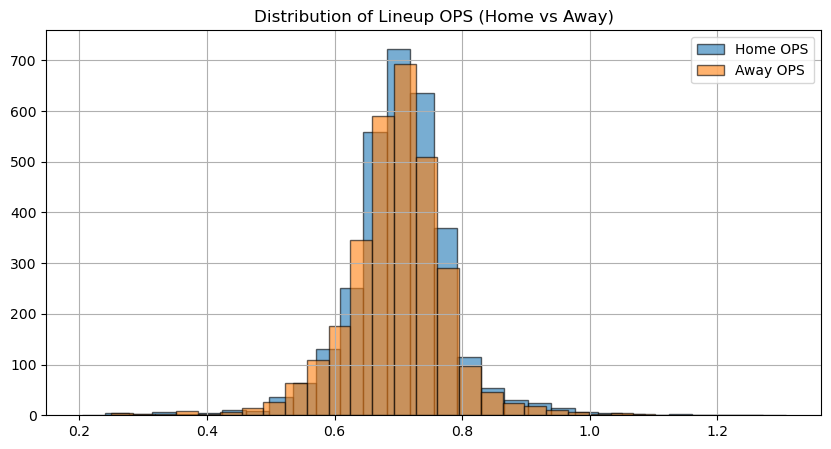

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
df['home_lineup_score'].hist(bins=30, label="Home OPS", alpha=0.6, edgecolor='black')
df['away_lineup_score'].hist(bins=30, label="Away OPS", alpha=0.6, edgecolor='black')
plt.title("Distribution of Lineup OPS (Home vs Away)")
plt.legend()
plt.show()

#### Concatenating with the final_game_logs.csv File

In [63]:
merged = game_logs.merge(df, on="game_id", how="left")
merged.to_csv("../data/final_game_logs.csv", index=False)

In [9]:
data = pd.read_csv("../data/final_game_logs.csv")

In [11]:
data.head()

,Unnamed: 0,game_id,home_name,away_name,home_probable_pitcher,away_probable_pitcher,away_score,home_score,home_ERA,home_ER,...,away_home_SO_batting,away_home_IBB,temp,condition,wind,condition_code,home_lineup_score,away_lineup_score,home_n_starters,away_n_starters
0,0,748266,San Diego Padres,Los Angeles Dodgers,Joe Musgrove,Gavin Stone,14,1,3.88,43.0,...,1336.0,33.0,71.0,Sunny,3.0,2,0.614000,0.833250,19,20
1,1,748344,Boston Red Sox,Northeastern Huskies,Helcris Olivárez,Aiven Cabral,2,7,NaN,NaN,...,NaN,NaN,75.0,Partly Cloudy,16.0,0,0.951000,0.453722,17,18
2,2,748263,Texas Rangers,Kansas City Royals,Dane Dunning,Daniel Lynch IV,4,5,5.31,56.0,...,1161.0,22.0,76.0,Partly Cloudy,9.0,0,0.648111,0.583333,18,18
3,3,748341,Chicago Cubs,Chicago White Sox,Jordan Wicks,Jesse Chavez,1,8,5.48,28.0,...,1403.0,8.0,75.0,Cloudy,6.0,3,0.666556,0.287000,18,18
4,4,748260,Los Angeles Dodgers,San Diego Padres,Landon Knack,Jhony Brito,1,4,3.65,28.0,...,1077.0,18.0,76.0,Cloudy,5.0,3,0.962647,0.271895,17,19


<Axes: >

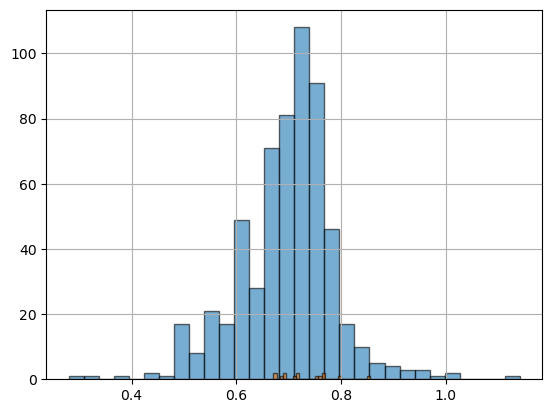

In [41]:
data[data['condition_code'] == 3]['home_lineup_score'].hist(bins=30, edgecolor='black', alpha=0.6)
data[data['condition_code'] == 9]['home_lineup_score'].hist(bins=30, edgecolor='black', alpha=0.6)

In [39]:
data['condition'].value_counts()

condition
Partly Cloudy    1040
Clear             653
Cloudy            589
Sunny             577
Roof Closed       381
Overcast          248
Dome               89
Drizzle            33
Unknown            20
Rain               14
Name: count, dtype: int64